In [1]:
import numpy as np
import matplotlib.pyplot as plt
from flow_decomposition import FlowDecomposition
from flow_regression import FlowRegression, WeightedFlowRegression

Toy data preparation.

In [2]:


#############################################
# Test example using mixed Lorenz systems   #
#############################################

def simulate_lorenz(initial, sigma=10, rho=28, beta=8/3, dt=0.01, steps=1000):
    """
    Simulate a Lorenz attractor using Euler integration.
    Returns an array of shape (steps, 3).
    """
    trajectory = np.empty((steps, 3))
    trajectory[0] = initial
    for i in range(1, steps):
        x, y, z = trajectory[i-1]
        dx = sigma * (y - x)
        dy = x * (rho - z) - y
        dz = x * y - beta * z
        trajectory[i] = trajectory[i-1] + dt * np.array([dx, dy, dz])
    return trajectory

steps = 10000

# Simulate three independent Lorenz attractors.
traj1 = simulate_lorenz(initial=[1.0, 1.0, 1.0], steps=steps)
traj2 = simulate_lorenz(initial=[0.1, -1.0, 1.0], steps=steps)
traj3 = simulate_lorenz(initial=[0.5, 0.5, 0.0], steps=steps)

# Stack the three trajectories horizontally.
# This yields a latent data matrix of shape (steps, 9) [3 systems x 3 dimensions each].
X_latent = np.hstack([traj1, traj2, traj3])

M = np.random.randn(X_latent.shape[1], 20)  

# Mix the latent signals to generate the observed data.
X_mixed = X_latent @ M  # shape (steps, observed_dim)
X_mixed = (X_mixed - X_mixed.mean(axis=0))/X_mixed.std(axis=0)


`FlowDecomposition` usage example. Decomposition of mixed Lorenz dynamics.

In [3]:

# Initialization parameters for FlowDecomposition.
init_params = {
    "input_dim": 20, 
    "proj_dim": 2,
    "n_components": 3,        
    "num_delays": 0,
    "delay_step": 0,
    "model": "linear",
    "subtract_autocorr": False,
    "device": "cpu",
    "data_device": "cpu",
    "optimizer": "Adagrad",
    "learning_rate": 0.1,
    "random_state": None
}

# Fit parameters.
fit_params = {
    "sample_size": 150,
    "library_size": 1000,
    "exclusion_rad": 20,
    "time_intv": 80,
    "num_epochs": 500,
    "num_rand_samples": 32,
    "batch_size": 32,
    "method": "knn",
    "nbrs_num": 16,
    "theta": 5,
    "beta": 0,
    "optim_policy": "range",
    "mask_size": None
}

fd = FlowDecomposition(**init_params)
fd.fit(X_mixed, **fit_params)

Epoch 1/500, Loss: 0.9192, ccm_loss: 0.9192, h_norm_loss: 0.8488
Epoch 2/500, Loss: 0.8907, ccm_loss: 0.8907, h_norm_loss: 0.8105
Epoch 3/500, Loss: 0.8847, ccm_loss: 0.8847, h_norm_loss: 0.7810
Epoch 4/500, Loss: 0.8256, ccm_loss: 0.8256, h_norm_loss: 0.7823
Epoch 5/500, Loss: 0.8057, ccm_loss: 0.8057, h_norm_loss: 0.7727
Epoch 6/500, Loss: 0.8296, ccm_loss: 0.8296, h_norm_loss: 0.7802
Epoch 7/500, Loss: 0.8243, ccm_loss: 0.8243, h_norm_loss: 0.7668
Epoch 8/500, Loss: 0.8297, ccm_loss: 0.8297, h_norm_loss: 0.7758
Epoch 9/500, Loss: 0.8029, ccm_loss: 0.8029, h_norm_loss: 0.7717
Epoch 10/500, Loss: 0.7855, ccm_loss: 0.7855, h_norm_loss: 0.7555
Epoch 11/500, Loss: 0.7646, ccm_loss: 0.7646, h_norm_loss: 0.7594
Epoch 12/500, Loss: 0.7197, ccm_loss: 0.7197, h_norm_loss: 0.7519
Epoch 13/500, Loss: 0.6908, ccm_loss: 0.6908, h_norm_loss: 0.7531
Epoch 14/500, Loss: 0.7324, ccm_loss: 0.7324, h_norm_loss: 0.7554
Epoch 15/500, Loss: 0.6884, ccm_loss: 0.6884, h_norm_loss: 0.7559
Epoch 16/500, Loss:

In [4]:
unmixed = fd.transform(X_mixed)

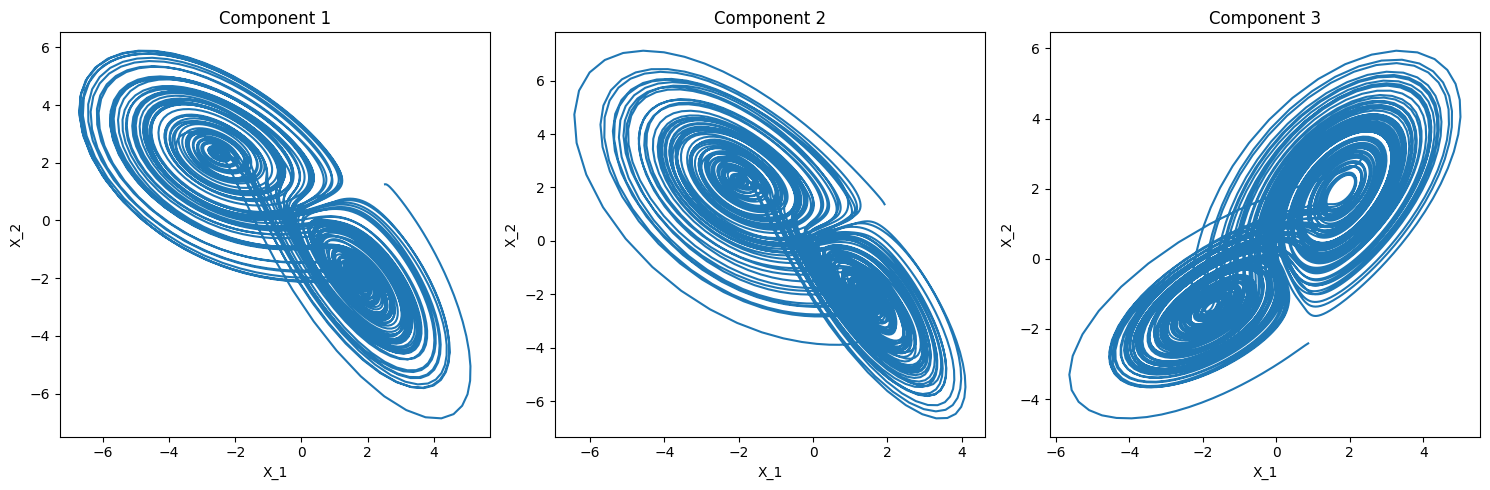

In [5]:

fig, axes = plt.subplots(nrows=1, ncols=unmixed.shape[1], figsize=(15, 5))
for i in range(unmixed.shape[1]):
    axes[i].plot(unmixed[:, i, 0], unmixed[:, i, 1])
    axes[i].set_title(f'Component {i+1}')
    axes[i].set_xlabel('X_1')
    axes[i].set_ylabel('X_2')
plt.tight_layout()
plt.show()

`FlowRegression` usage example. Projecting mixed Lorenz dynamics onto the space where they cross-map to one of the original Lorenz systems.

In [6]:

# Initialization parameters for FlowRegression.
init_params = {
    "input_dim": 20, 
    "proj_dim": 2,
    "num_delays": 3,
    "delay_step": 10,
    "model": "linear",
    "subtract_autocorr": False,
    "device": "cpu",
    "data_device": "cpu",
    "optimizer": "Adagrad",
    "learning_rate": 0.01,
    "random_state": None
}

# Fit parameters.
fit_params = {
    "sample_size": 150,
    "library_size": 1000,
    "exclusion_rad": 20,
    "time_intv": 80,
    "num_epochs": 500,
    "num_rand_samples": 32,
    "batch_size": 32,
    "method": "knn",
    "nbrs_num": 16,
    "theta": 5,
    "beta": 0,
    "optim_policy": "range"

}
y = traj1[:,:]

fd = FlowRegression(**init_params)
fd.fit(X=X_mixed, Y=y, **fit_params)

Epoch 1/500, CCM Loss: 0.7000, h_norm: 0.8805, Total Loss: 0.7000
Epoch 2/500, CCM Loss: 0.6023, h_norm: 0.8805, Total Loss: 0.6023
Epoch 3/500, CCM Loss: 0.5259, h_norm: 0.8760, Total Loss: 0.5259
Epoch 4/500, CCM Loss: 0.5070, h_norm: 0.8749, Total Loss: 0.5070
Epoch 5/500, CCM Loss: 0.4530, h_norm: 0.8722, Total Loss: 0.4530
Epoch 6/500, CCM Loss: 0.4352, h_norm: 0.8716, Total Loss: 0.4352
Epoch 7/500, CCM Loss: 0.4260, h_norm: 0.8702, Total Loss: 0.4260
Epoch 8/500, CCM Loss: 0.4170, h_norm: 0.8688, Total Loss: 0.4170
Epoch 9/500, CCM Loss: 0.4078, h_norm: 0.8681, Total Loss: 0.4078
Epoch 10/500, CCM Loss: 0.3851, h_norm: 0.8686, Total Loss: 0.3851
Epoch 11/500, CCM Loss: 0.3745, h_norm: 0.8689, Total Loss: 0.3745
Epoch 12/500, CCM Loss: 0.3651, h_norm: 0.8694, Total Loss: 0.3651
Epoch 13/500, CCM Loss: 0.3645, h_norm: 0.8698, Total Loss: 0.3645
Epoch 14/500, CCM Loss: 0.3386, h_norm: 0.8689, Total Loss: 0.3386
Epoch 15/500, CCM Loss: 0.3422, h_norm: 0.8684, Total Loss: 0.3422
Epoc

In [8]:
unmixed = fd.transform(X_mixed)

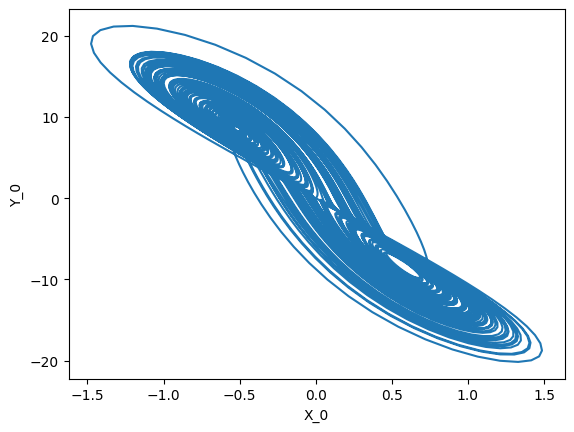

In [9]:
plt.plot(unmixed[:,0],y[:,0])
plt.xlabel('X_0')
plt.ylabel('Y_0')
plt.show()

`WeightedFlowRegression` usage example. Projecting mixed Lorenz dynamics onto the space where they cross-map to one of the original Lorenz systems.

In [3]:

# Initialization parameters for WeightedFlowRegression.
init_params = {
    "input_dim": 20, 
    "proj_dim": 2,
    "num_delays": 3,
    "delay_step": 10,
    "model": "linear",
    "subtract_autocorr": False,
    "device": "cpu",
    "data_device": "cpu",
    "optimizer": "Adagrad",
    "learning_rate": 0.01,
    "random_state": None
}

# Fit parameters.
fit_params = {
    "sample_size": 150,
    "library_size": 1000,
    "exclusion_rad": 20,
    "time_intv": 80,
    "num_epochs": 500,
    "num_rand_samples": 32,
    "batch_size": 32,
    "method": "knn",
    "nbrs_num": 16,
    "theta": 5,
    "beta": 0,
    "optim_policy": "range"

}
y = traj1[:,:]

fd = WeightedFlowRegression(**init_params)
fd.fit(X=X_mixed, Y=y, **fit_params)

Epoch 1/500, CCM Loss: 0.6096, h_norm: 0.8434, Total Loss: 0.6096
Epoch 2/500, CCM Loss: 0.5240, h_norm: 0.8433, Total Loss: 0.5240
Epoch 3/500, CCM Loss: 0.5002, h_norm: 0.8314, Total Loss: 0.5002
Epoch 4/500, CCM Loss: 0.4387, h_norm: 0.8312, Total Loss: 0.4387
Epoch 5/500, CCM Loss: 0.4279, h_norm: 0.8296, Total Loss: 0.4279
Epoch 6/500, CCM Loss: 0.4101, h_norm: 0.8294, Total Loss: 0.4101
Epoch 7/500, CCM Loss: 0.3961, h_norm: 0.8308, Total Loss: 0.3961
Epoch 8/500, CCM Loss: 0.3739, h_norm: 0.8311, Total Loss: 0.3739
Epoch 9/500, CCM Loss: 0.3678, h_norm: 0.8314, Total Loss: 0.3678
Epoch 10/500, CCM Loss: 0.3526, h_norm: 0.8310, Total Loss: 0.3526
Epoch 11/500, CCM Loss: 0.3433, h_norm: 0.8303, Total Loss: 0.3433
Epoch 12/500, CCM Loss: 0.3451, h_norm: 0.8293, Total Loss: 0.3451
Epoch 13/500, CCM Loss: 0.3317, h_norm: 0.8291, Total Loss: 0.3317
Epoch 14/500, CCM Loss: 0.3302, h_norm: 0.8289, Total Loss: 0.3302
Epoch 15/500, CCM Loss: 0.3180, h_norm: 0.8283, Total Loss: 0.3180
Epoc

In [4]:
unmixed = fd.transform(X_mixed)
weights = fd.predict_weights(X_mixed)

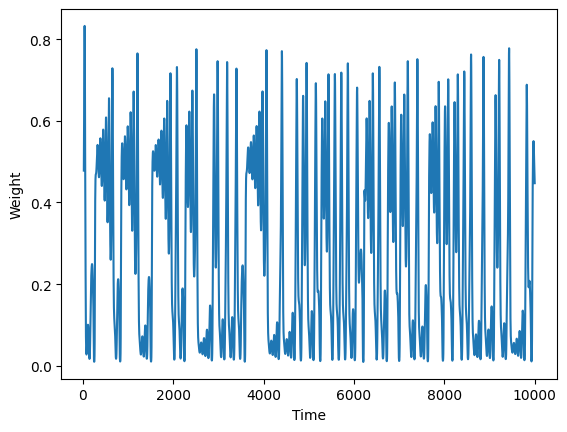

In [10]:
plt.plot(weights[:,0])
plt.xlabel('Time')
plt.ylabel('Weight')
plt.show()

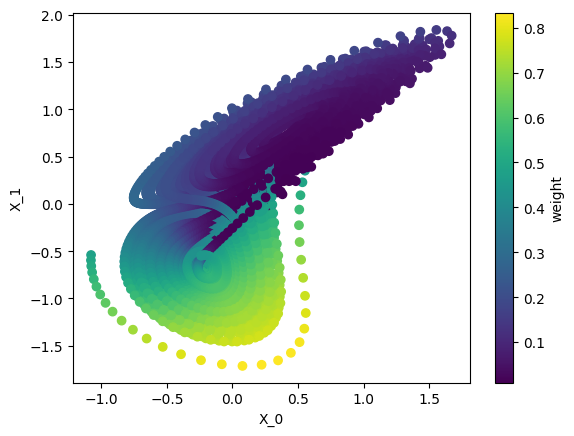

In [11]:
plt.scatter(unmixed[:,0],unmixed[:,1],c=weights[:,0])
plt.xlabel('X_0')
plt.ylabel('X_1')
plt.colorbar(label="weight")
plt.show()